# Drugs and medications correlation matrix

In [275]:
import difflib
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
import seaborn as sns

%matplotlib inline

## Relative Risk

The Relative Risk (RR) of observing a pair of diseases $i$ and $j$ affecting the same patient is given by

$$RR_ij = \frac{C_ijN}{P_iP_j}$$ where $C_ij$ is the number of patients affected by both diseases, $N$ is the total number of patients in the population and $P_i$ and $P_j$ are the prevalences of diseases $i$ and $j$.

In [276]:
from __future__ import division

def RR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    return (c[i,j]*N)/(c[i,i]*c[j,j])

## Conditions database

In [280]:
ds = pd.read_csv('../output/conditions/data.csv', low_memory=False)
ds_drop = ds.dropna().copy()
ds_drop.rename(columns=lambda x: x.replace('ENFERMEDADES_', ''), inplace=True)
conditions = ds_drop
conditions.head()

,entity_id,CANCER,DIABETES,HTA,HIPERCOLESTEROLEMIA,ICTUS,INFARTO,ANGINA,HELICOBACTER,CROHN,...,ESQUIZOFRENIA,ALZHEIMER,PARKINSON,GENETICA_HEREDITARIA,OTRAS,NINGUNA,NS_NC,DIABETES_T1DM,DIABETES_T2DM,DIABETES_GESTACIONAL
0,=E00251439708521,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,=E00251432416521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,=E00251429328121,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251513157121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,=E00251429815021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Medication database

In [278]:
ds = pd.read_csv('../output/medications/data.csv', low_memory=False)
ds['ATC_CODE_3'] = ds['ATC_CODE'].str[0:3]
ds_drop = ds.drop('entity_id', 1).dropna()

ds = ds.drop('CONDITION', 1)
ds = ds.drop('DRUG_NAME', 1)
ds = ds.drop('ATC_CODE', 1)

ds_drop = ds.drop_duplicates().copy()
ds_drop['COUNT'] = 1
ds_drop = pd.pivot_table(ds_drop, index='entity_id', columns='ATC_CODE_3', values='COUNT', aggfunc=np.sum)
ds_drop = ds_drop.fillna(0)

pd.DataFrame(ds_drop).to_csv('../output/medications/atc_code3.csv')
medications = pd.read_csv('../output/medications/atc_code3.csv', low_memory=False)
medications.head()

,entity_id,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,R01,R02,R03,R05,R06,S01,V01,V03,V04,V07
0,=E00251413396521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251413396721,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251413396921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251413398721,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,=E00251413471721,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
phenotypes = pd.merge(medications, conditions, on='entity_id')
phenotypes = phenotypes.drop('entity_id', 1)

## Calculate comorbidity frequency

In [282]:
phenotypes_matrix = phenotypes.as_matrix().astype(int)
coocurrences = phenotypes_matrix.T.dot(phenotypes_matrix)

## Calculate comorbidity relative risk

In [312]:
N = phenotypes.shape[0]
risk = coocurrences.copy().astype(float)

for i in range(0, coocurrences.shape[0], 1):
    for j in range(0, coocurrences.shape[1], 1):
        risk[i,j] = RR(coocurrences, N, i, j)
        
risk = pd.DataFrame(risk, columns=phenotypes.columns, index=phenotypes.columns)
risk.to_csv('../output/relative-risk/drugs and conditions.csv')

## Medications and drug matrices

In [313]:
medication_matrix_columns = medications.columns.drop('entity_id')
conditions_matrix_columns = conditions.columns.drop('entity_id')

risk = risk.loc[medication_matrix_columns][conditions_matrix_columns]
risk.index

Index(['A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11',
       'A12', 'A16', 'B01', 'B02', 'B03', 'B05', 'C01', 'C02', 'C03', 'C04',
       'C05', 'C07', 'C08', 'C09', 'C10', 'D01', 'D03', 'D04', 'D05', 'D06',
       'D07', 'D08', 'D10', 'D11', 'G01', 'G02', 'G03', 'G04', 'H01', 'H02',
       'H03', 'H05', 'J01', 'J02', 'J04', 'J05', 'J07', 'L01', 'L02', 'L04',
       'M01', 'M02', 'M03', 'M04', 'M05', 'M09', 'N01', 'N02', 'N03', 'N04',
       'N05', 'N06', 'N07', 'P01', 'R01', 'R02', 'R03', 'R05', 'R06', 'S01',
       'V01', 'V03', 'V04', 'V07'],
      dtype='object')

In [314]:
atc = pd.read_csv('../data/medications/ATC.csv', low_memory=False)
atc.head()

,id,text,parent
0,A,Alimentary tract and metabolism,NaN
1,A02,Drugs for acid related disorders,A
2,A02B,Drugs for treatment of peptic ulcer,A02
3,A02BC,Proton pump inhibitors,A02B
4,A02BC01,Omeprazole,A02BC


In [315]:
def filterRR(df, RR):
    risk_df = pd.DataFrame(df)
    risk_df['condition'] = risk_df.index
    risk_df = pd.melt(risk_df, id_vars=['condition'])
    risk_df = risk_df[risk_df['value'] > RR].sort_values(by=['value'], ascending=[0])
    risk_df_pivot = risk_df.pivot(index='condition', columns='variable')['value']
    risk_df_pivot = risk_df_pivot.fillna(0)
    return risk_df_pivot

## Plot disease relative risk matrix

<module 'matplotlib.pyplot' from '/software/debian-8/general/virtenvs/jupyter/lib/python3.5/site-packages/matplotlib/pyplot.py'>

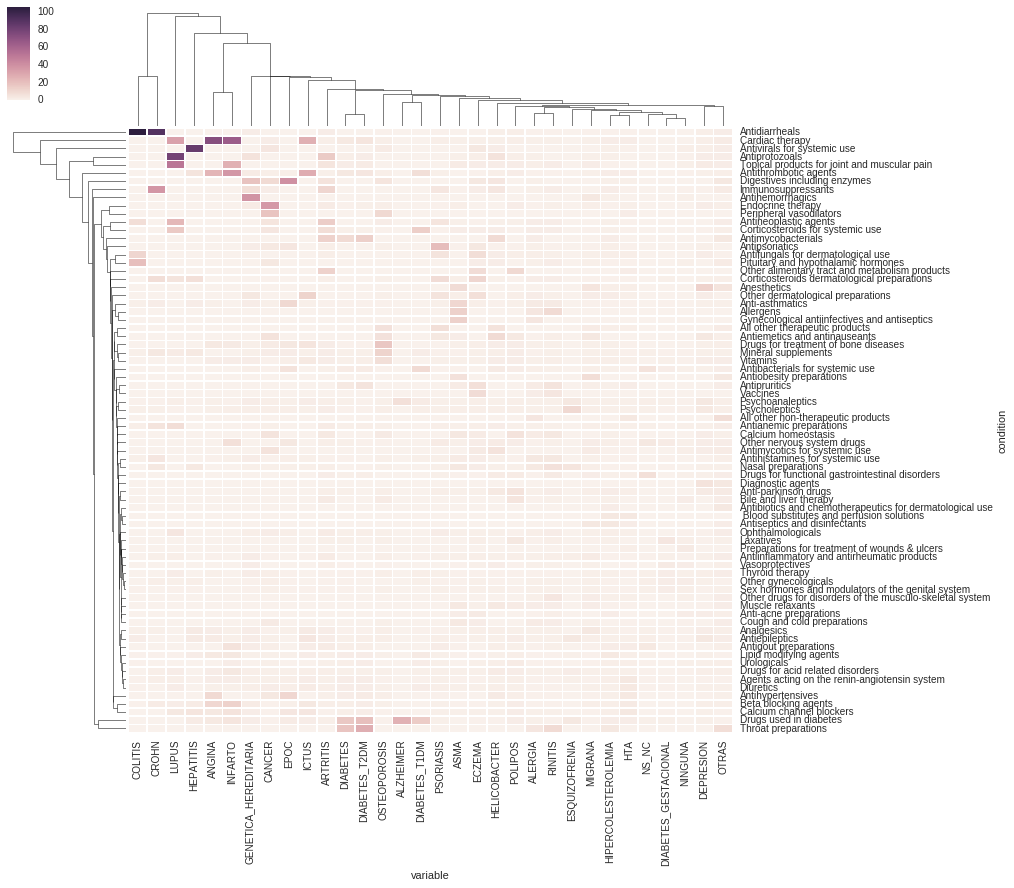

In [317]:
df = risk.copy()
df.index = atc[atc.id.isin(df.index)].text
df = filterRR(df, 0)

cg = sns.clustermap(df, linewidths=.5, figsize=(13, 13))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt